<a href="https://colab.research.google.com/github/Prachi09062003/Research_project/blob/main/project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

In [ ]:
# Load the dataset
data_path = '/content/reduced_dataset.csv'
df = pd.read_csv(data_path)

In [ ]:
# Drop the 'text' column
df = df.drop(columns=['text'])

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
depression      0
cleaned_text    5
dtype: int64


In [ ]:
#Drop the missing values
df = df.dropna(subset=['cleaned_text'])

In [ ]:
# Exploratory Data Analysis (EDA)
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Head:
   depression                                       cleaned_text
0           0  struggling many year mental issue believe foun...
1           0  run youtube channel whereby approach people st...
2           0  little im marine veteran disabled ptsd adhd in...
3           0                    passed exam thought sure failed
4           0  jail foster care ruined personality traumatize...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   depression    995 non-null    int64 
 1   cleaned_text  995 non-null    object
dtypes: int64(1), object(1)
memory usage: 23.3+ KB
None


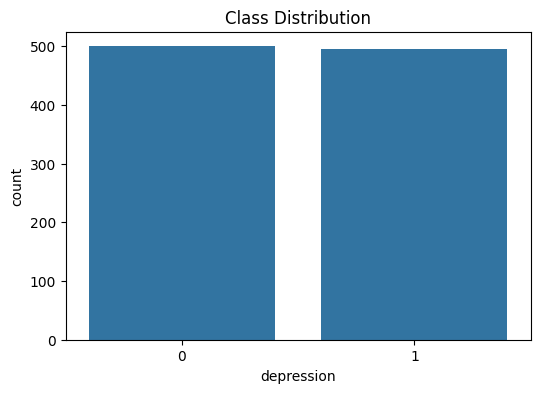

In [ ]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='depression', data=df)
plt.title('Class Distribution')
plt.show()

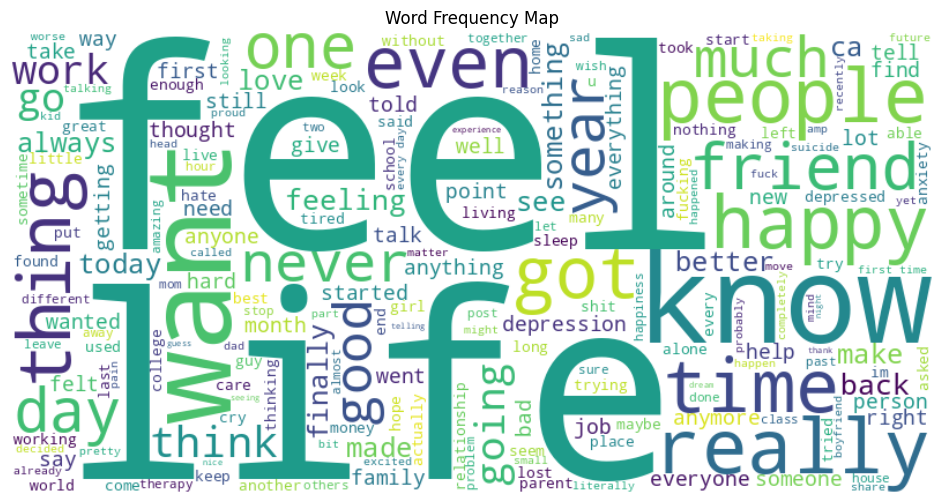

In [ ]:
# Word Frequency Map
from wordcloud import WordCloud

plt.figure(figsize=(12, 6))
text_data = " ".join(df['cleaned_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency Map')
plt.show()

In [ ]:
# Preprocessing
X = df['cleaned_text']
y = df['depression']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

train_encodings = tokenize_texts(X_train, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Handling class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

Class Weights: {0: 0.995, 1: 1.005050505050505}


In [ ]:
# Convert labels to tensors
y_train = tf.convert_to_tensor(y_train.values)
y_test = tf.convert_to_tensor(y_test.values)

In [ ]:
# Model setup
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Summarize the model
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(
    x={"input_ids": train_encodings['input_ids'], "attention_mask": train_encodings['attention_mask']},
    y=y_train,
    validation_data=(
        {"input_ids": test_encodings['input_ids'], "attention_mask": test_encodings['attention_mask']}, y_test
    ),
    epochs=10,  # Reduced epochs to 5 for faster runtime
    batch_size=32,  # Batch size
    class_weight=class_weights  # Class weights to handle imbalance
)

Epoch 1/10
25/25 [==============================] - 630s 25s/step - loss: 0.0358 - accuracy: 0.9887 - val_loss: 0.5138 - val_accuracy: 0.8643
Epoch 2/10
25/25 [==============================] - 668s 27s/step - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.5797 - val_accuracy: 0.8744
Epoch 3/10
25/25 [==============================] - 670s 27s/step - loss: 0.0335 - accuracy: 0.9899 - val_loss: 0.9058 - val_accuracy: 0.8040
Epoch 4/10
25/25 [==============================] - 657s 26s/step - loss: 0.0332 - accuracy: 0.9887 - val_loss: 0.5062 - val_accuracy: 0.8693
Epoch 5/10
25/25 [==============================] - 658s 26s/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.5007 - val_accuracy: 0.8894
Epoch 6/10
25/25 [==============================] - 659s 27s/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.5815 - val_accuracy: 0.8744
Epoch 7/10
25/25 [==============================] - 625s 25s/step - loss: 0.0188 - accuracy: 0.9899 - val_loss: 0.6999 - val_accuracy: 0.8492
Epoch 

In [ ]:
# Evaluation
print("\nEvaluating the model...")
loss, accuracy = model.evaluate(
    x={"input_ids": test_encodings['input_ids'], "attention_mask": test_encodings['attention_mask']},
    y=y_test
)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Evaluating the model...
7/7 [==============================] - 61s 8s/step - loss: 0.6657 - accuracy: 0.8744
Test Loss: 0.6657273769378662
Test Accuracy: 0.8743718862533569


In [ ]:
# Classification Report
predictions = model.predict({"input_ids": test_encodings['input_ids'], "attention_mask": test_encodings['attention_mask']}).logits
y_pred = np.argmax(predictions, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 52s 6s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       100
           1       0.89      0.86      0.87        99

    accuracy                           0.87       199
   macro avg       0.87      0.87      0.87       199
weighted avg       0.87      0.87      0.87       199



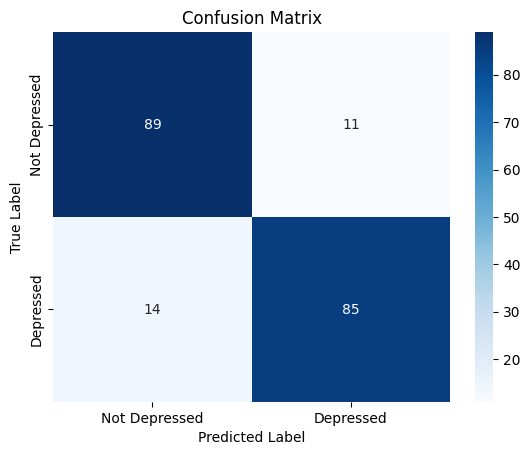

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

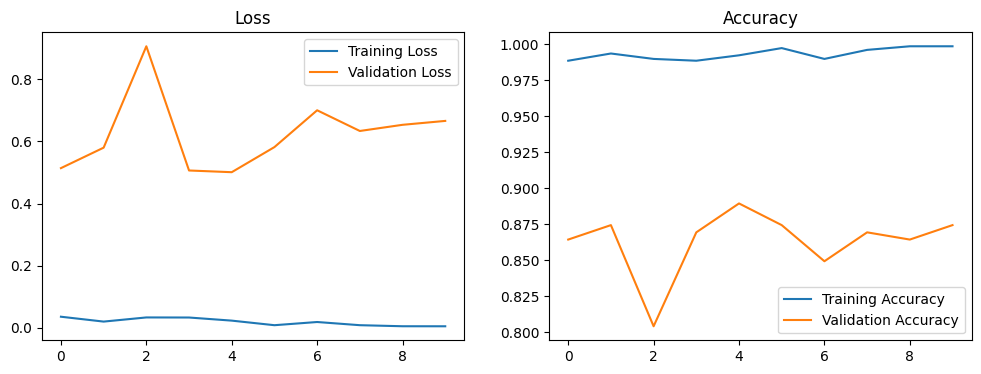

In [ ]:
# Visualize training performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
#Save the model
model.save_pretrained("depression_detection_model")
tokenizer.save_pretrained("depression_detection_model")

('depression_detection_model/tokenizer_config.json',
 'depression_detection_model/special_tokens_map.json',
 'depression_detection_model/vocab.txt',
 'depression_detection_model/added_tokens.json')

In [ ]:
#Download this model
from google.colab import files
files.download('depression_detection_model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>